In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
from statsmodels.stats.multitest import multipletests

In [3]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [4]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(facecolor='white', color_map='viridis_r')
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

/home/marcc/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.4 scipy==1.9.3 pandas==1.5.1 scikit-learn==1.1.3 statsmodels==0.13.5 pynndescent==0.5.8


## 1. In Vitro analysis

In [5]:
adata = sc.read_h5ad('/opt/marcc/GSE131604.h5ad')
vitro = adata[adata.obs["In vitro/ in vivo"] == "in vitro"]

/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


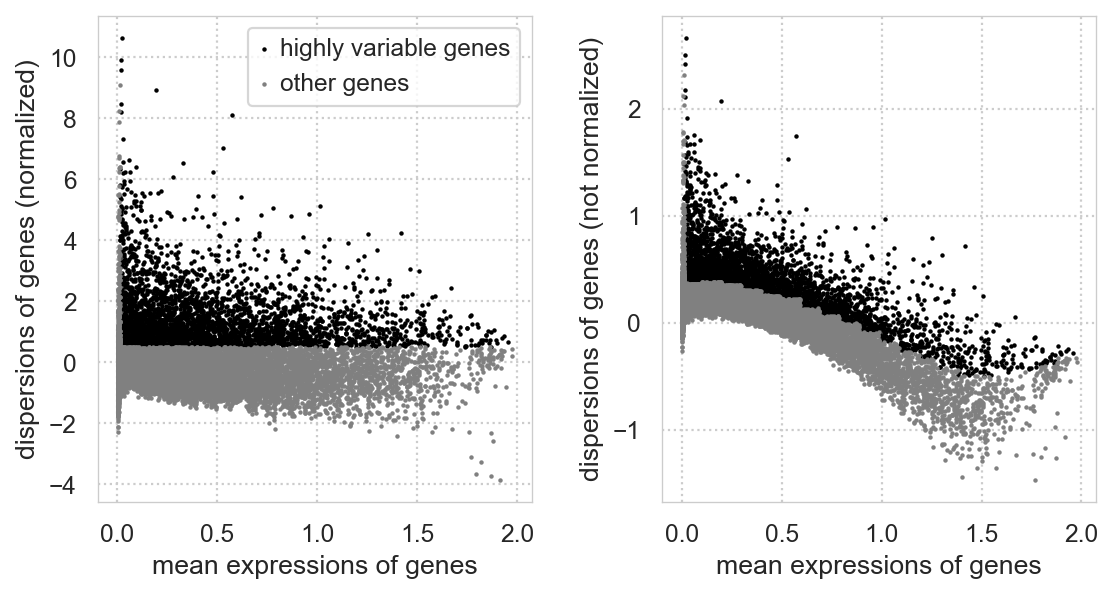

/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [6]:
sc.pp.filter_cells(vitro, min_genes=200)
sc.pp.filter_genes(vitro, min_cells=2)
vitro.var['mt'] = vitro.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(vitro, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
vitro = vitro[vitro.obs.pct_counts_mt < 1, :]
sc.pp.normalize_total(vitro, target_sum=1e4)
sc.pp.log1p(vitro)
sc.pp.highly_variable_genes(vitro, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(vitro)
sc.pp.scale(vitro, max_value=10)
vitro.raw = vitro
vitro = vitro[:, vitro.var.highly_variable]
sc.pp.scale(vitro, max_value=10)

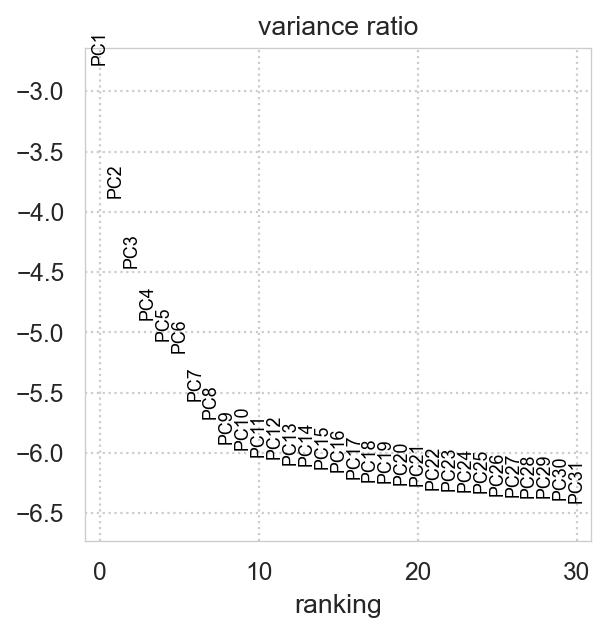

In [7]:
sc.tl.pca(vitro, svd_solver='arpack')
sc.pl.pca_variance_ratio(vitro, log=True)

/home/marcc/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/marcc/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


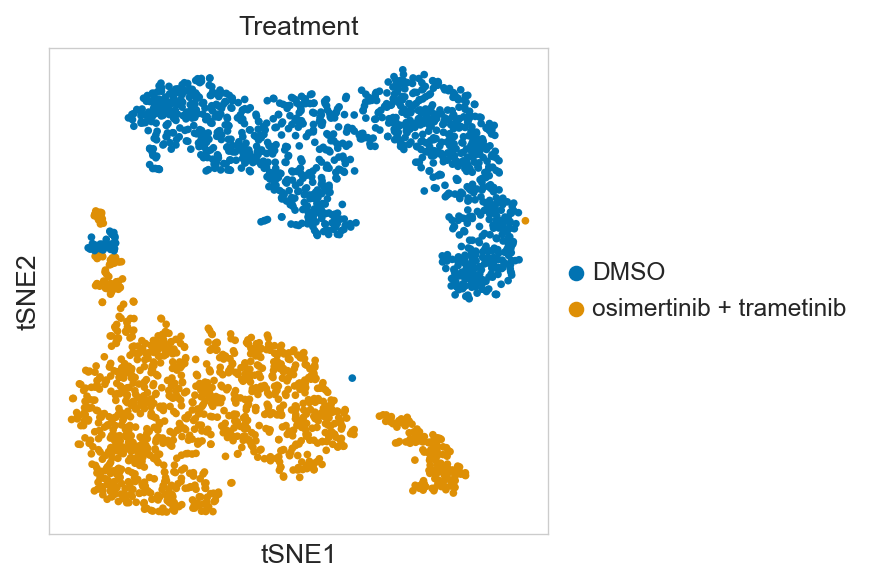

In [8]:
sc.tl.pca(vitro, svd_solver='arpack')
sc.tl.tsne(vitro, n_pcs=10, perplexity=30)
sc.pl.tsne(vitro, color=["Treatment"])

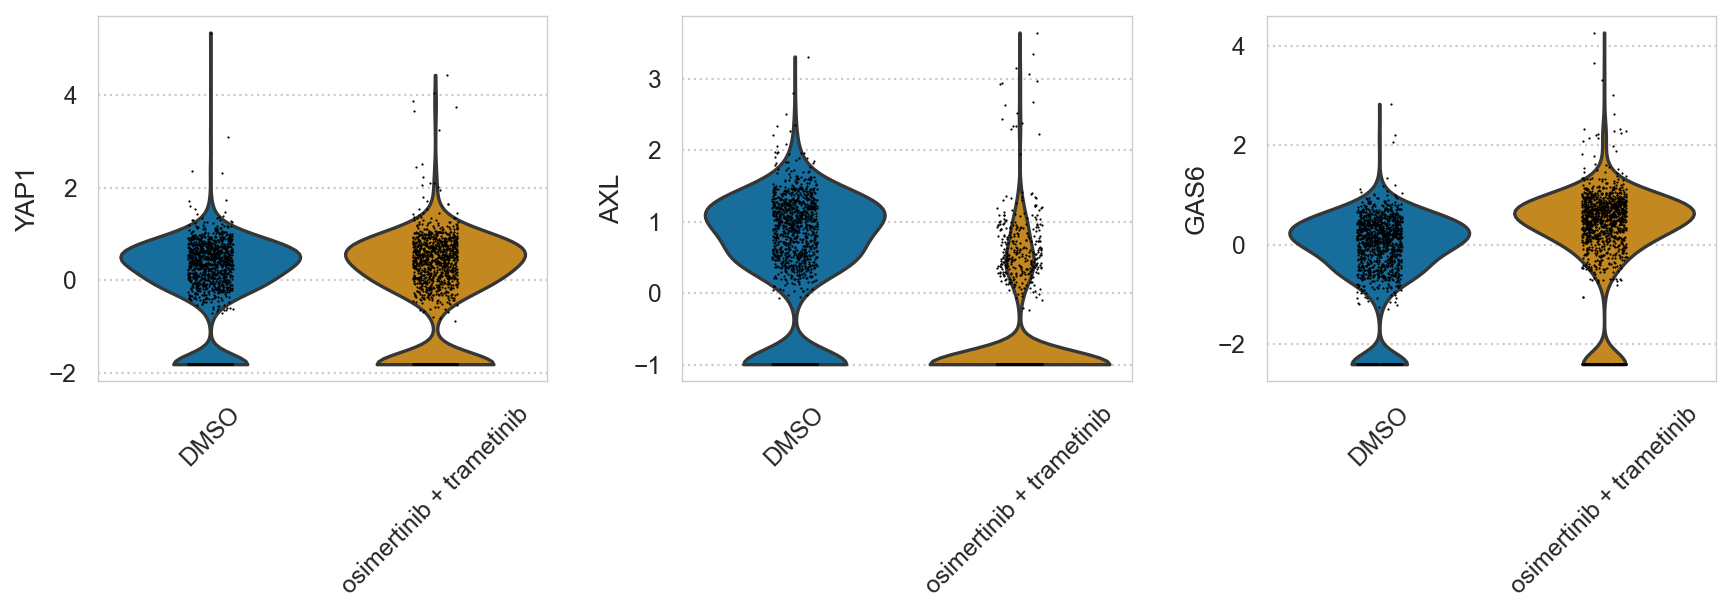

In [9]:
with plt.rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(vitro, keys=['YAP1', 'AXL', 'GAS6'], groupby='Treatment', rotation=45, order=["DMSO", "osimertinib + trametinib"])

/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


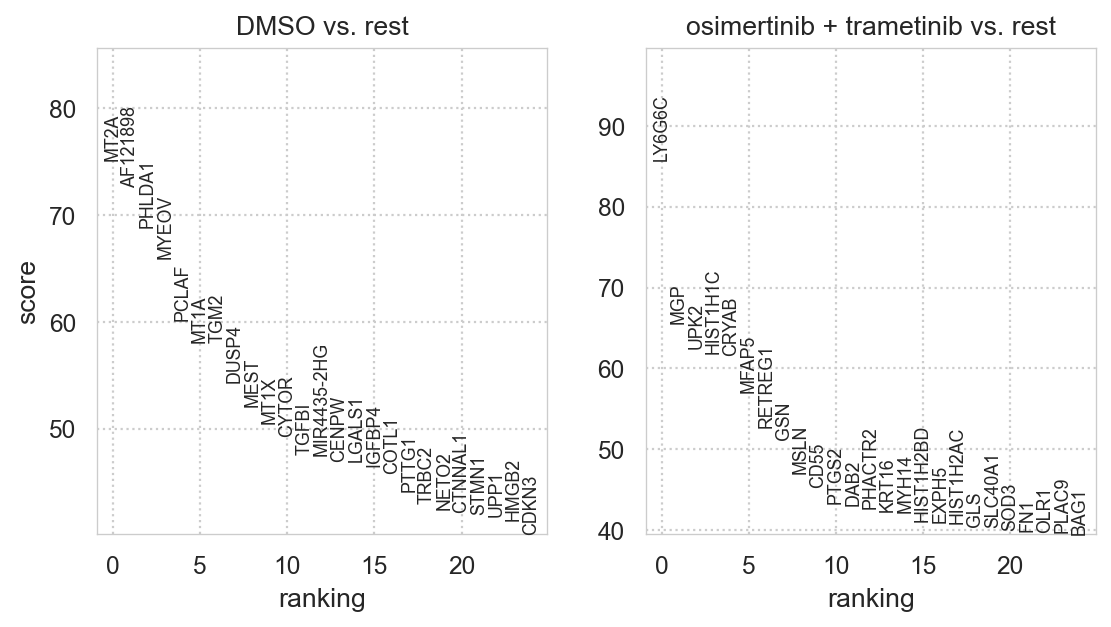

In [10]:
sc.tl.rank_genes_groups(vitro, 'Treatment', method='t-test', key_added = "t-test")
sc.pl.rank_genes_groups(vitro, n_genes=25, sharey=False, key = "t-test")

/home/marcc/.local/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


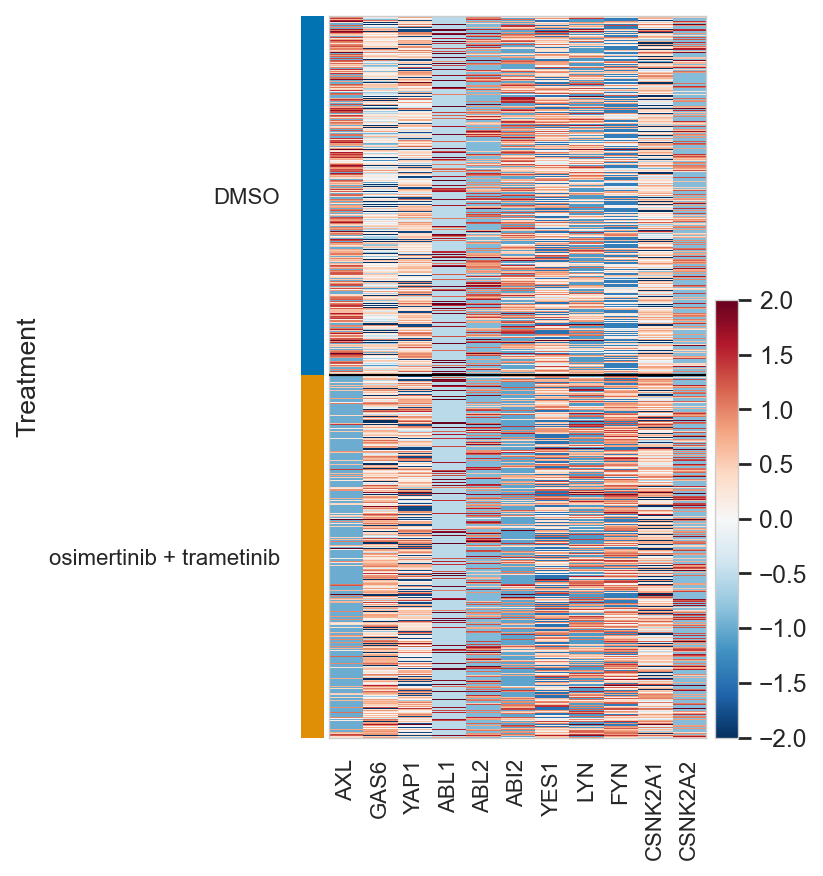

In [11]:
with plt.rc_context({'figure.figsize': (4, 8)}):
    sc.pl.heatmap(vitro, ["AXL", "GAS6", "YAP1", "ABL1", "ABL2", "ABI2", "YES1", "LYN", "FYN", 'CSNK2A1', "CSNK2A2"], groupby='Treatment', swap_axes=False, vmin=-2, vmax=2, cmap='RdBu_r')

## 2. In Vivo analysis

/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


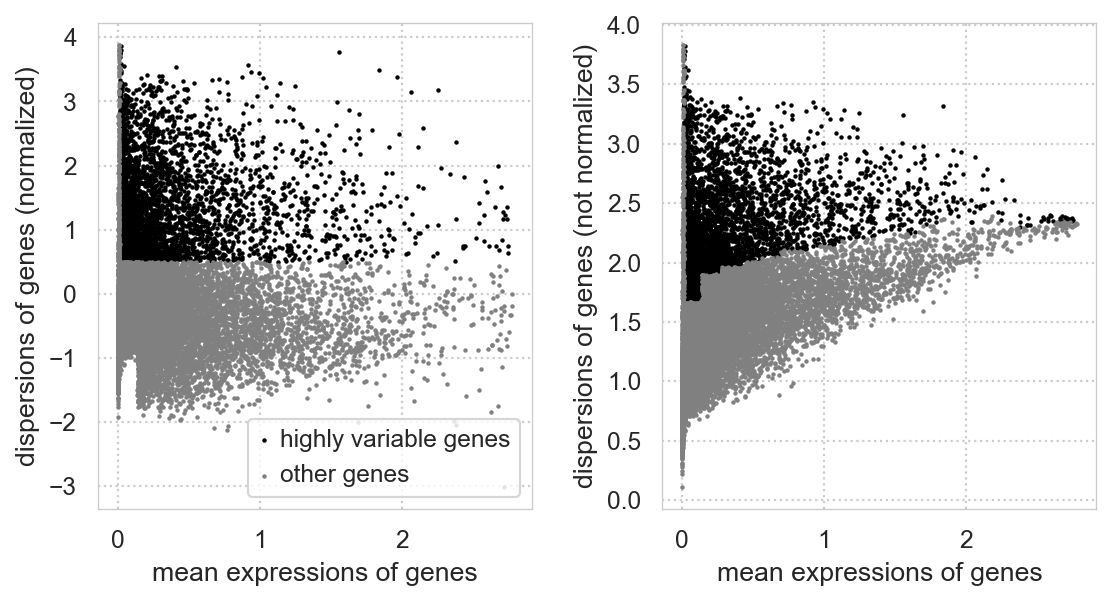

/home/marcc/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
adata = sc.read_h5ad('/opt/marcc/GSE131604.h5ad')
vivo = adata[adata.obs["In vitro/ in vivo"] == "in vivo"]

sc.pp.filter_cells(vivo, min_genes=200)
sc.pp.filter_genes(vivo, min_cells=2)
vivo.var['mt'] = vivo.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(vivo, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
vivo = vivo[vivo.obs.pct_counts_mt < 1, :]
sc.pp.normalize_total(vivo, target_sum=1e4)
sc.pp.log1p(vivo)
sc.pp.highly_variable_genes(vivo, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(vivo)
sc.pp.scale(vivo, max_value=10)
vivo.raw = vivo
vivo = vivo[:, vivo.var.highly_variable]
sc.pp.scale(vivo, max_value=10)

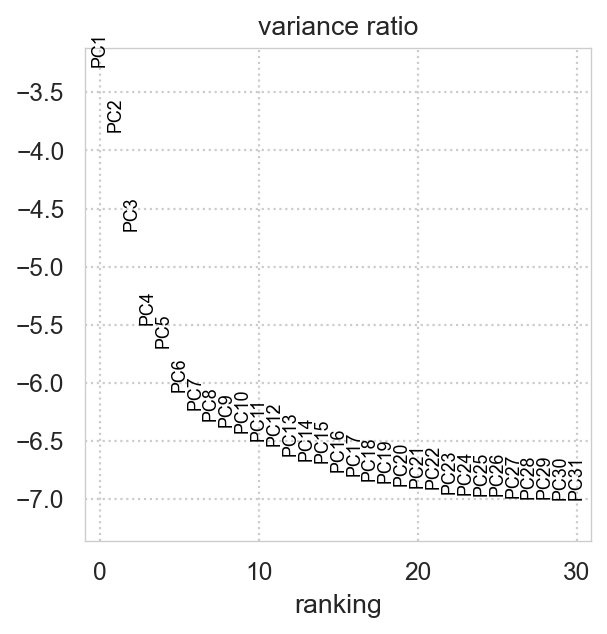

In [13]:
sc.tl.pca(vivo, svd_solver='arpack')
sc.pl.pca_variance_ratio(vivo, log=True)

In [14]:
sc.tl.pca(vivo, svd_solver='arpack')
sc.tl.tsne(vivo, n_pcs=15, perplexity=30)

/home/marcc/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


/home/marcc/.local/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


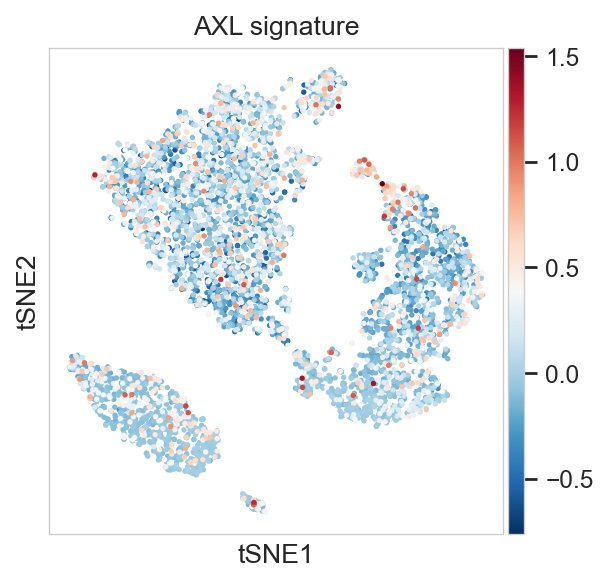

In [15]:
# calculate score: option 1
sc.tl.score_genes(vivo, ["GAS6", "PLK1", "YAP1", "ABL1", "ABL2", "ABI2", "YES1", "LYN", "FYN", 'CSNK2A1', "CSNK2A2"], score_name='AXL signature') 

# drawing graph
sc.pl.tsne(vivo, color='AXL signature', cmap='RdBu_r')

/home/marcc/.local/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


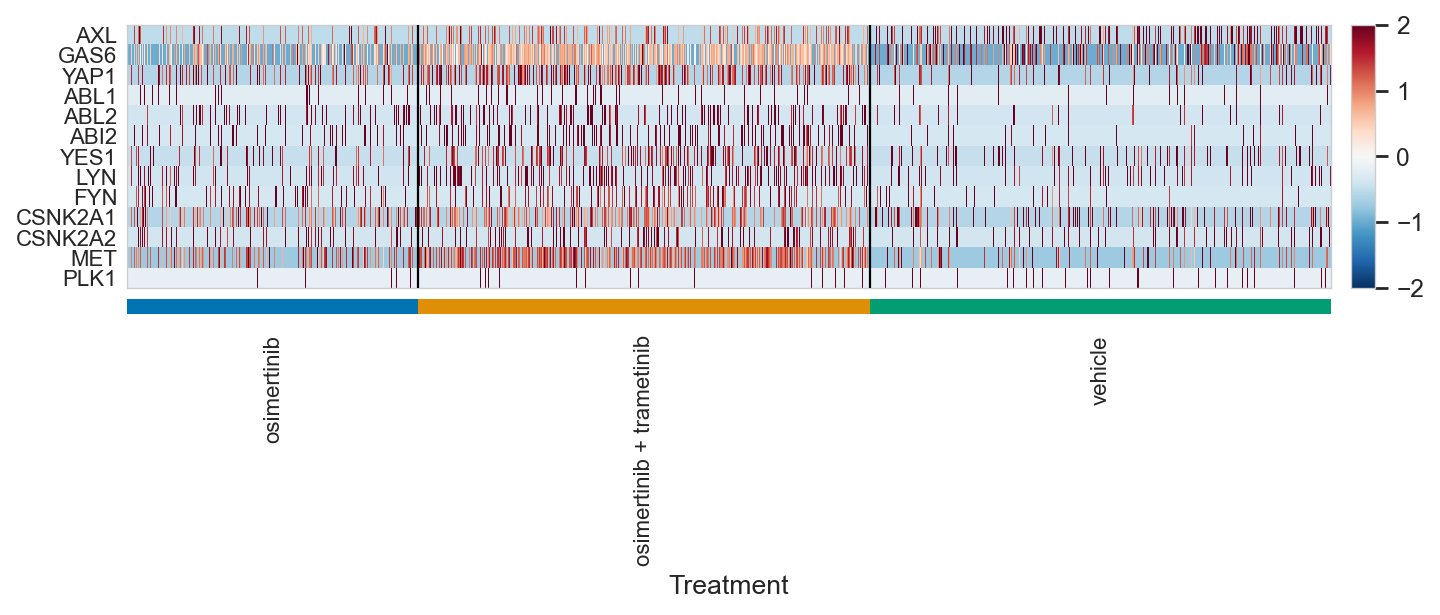

In [16]:
with plt.rc_context({'figure.figsize': (4, 8)}):
    sc.pl.heatmap(vivo, ["AXL", "GAS6", "YAP1", "ABL1", "ABL2", "ABI2", "YES1", "LYN", "FYN", 'CSNK2A1', "CSNK2A2", "MET", "PLK1"], groupby='Treatment', swap_axes=True, vmin=-2, vmax=2, cmap='RdBu_r')

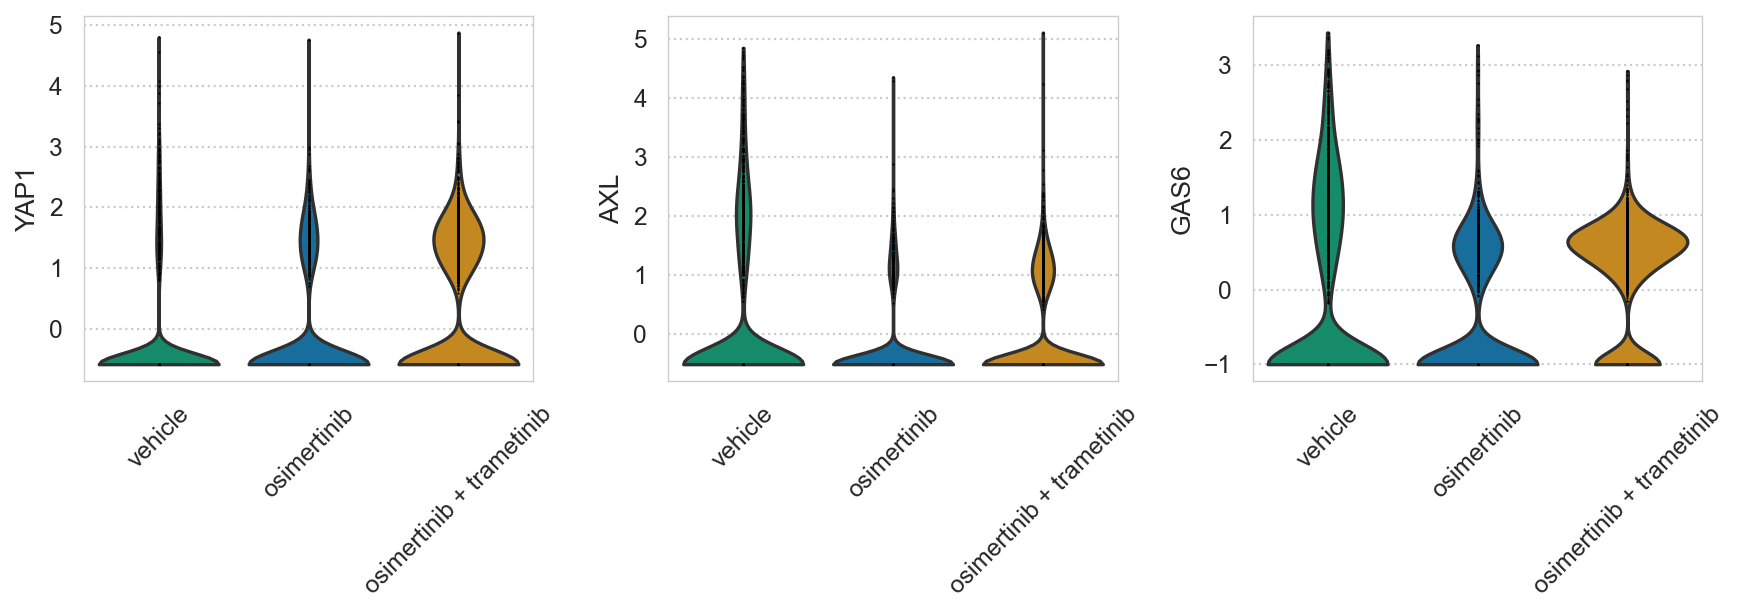

In [7]:
with plt.rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(vivo, keys=['YAP1', 'AXL', "GAS6"], jitter=False, groupby='Treatment', rotation=45, order=["vehicle", "osimertinib", "osimertinib + trametinib"])

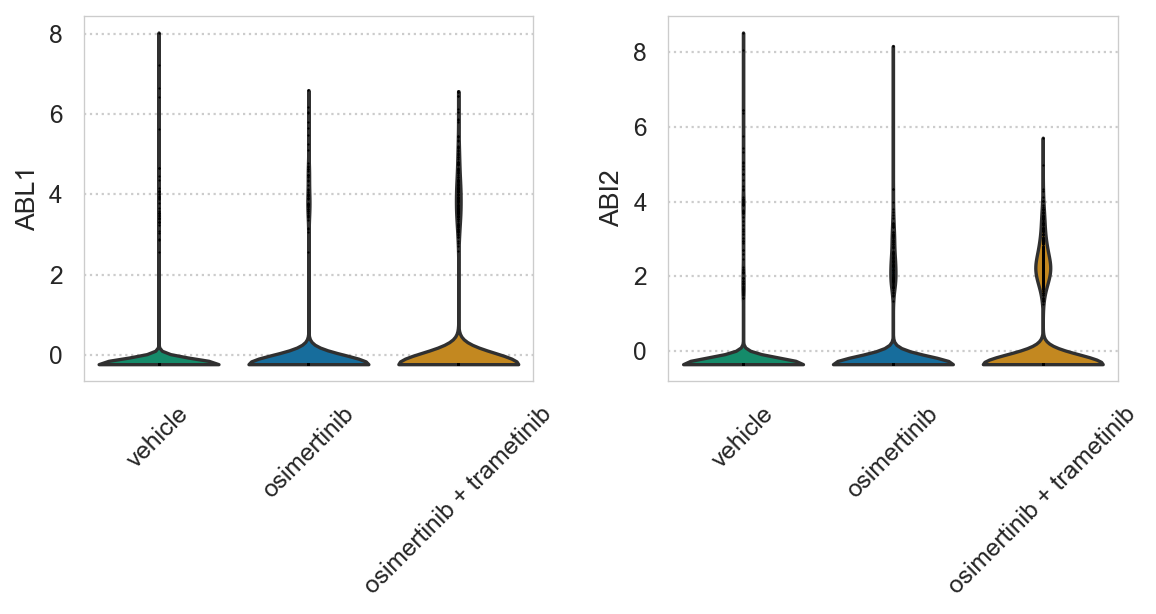

In [8]:
with plt.rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(vivo, keys=['ABL1', 'ABI2'], jitter=False, groupby='Treatment', rotation=45, order=["vehicle", "osimertinib", "osimertinib + trametinib"])

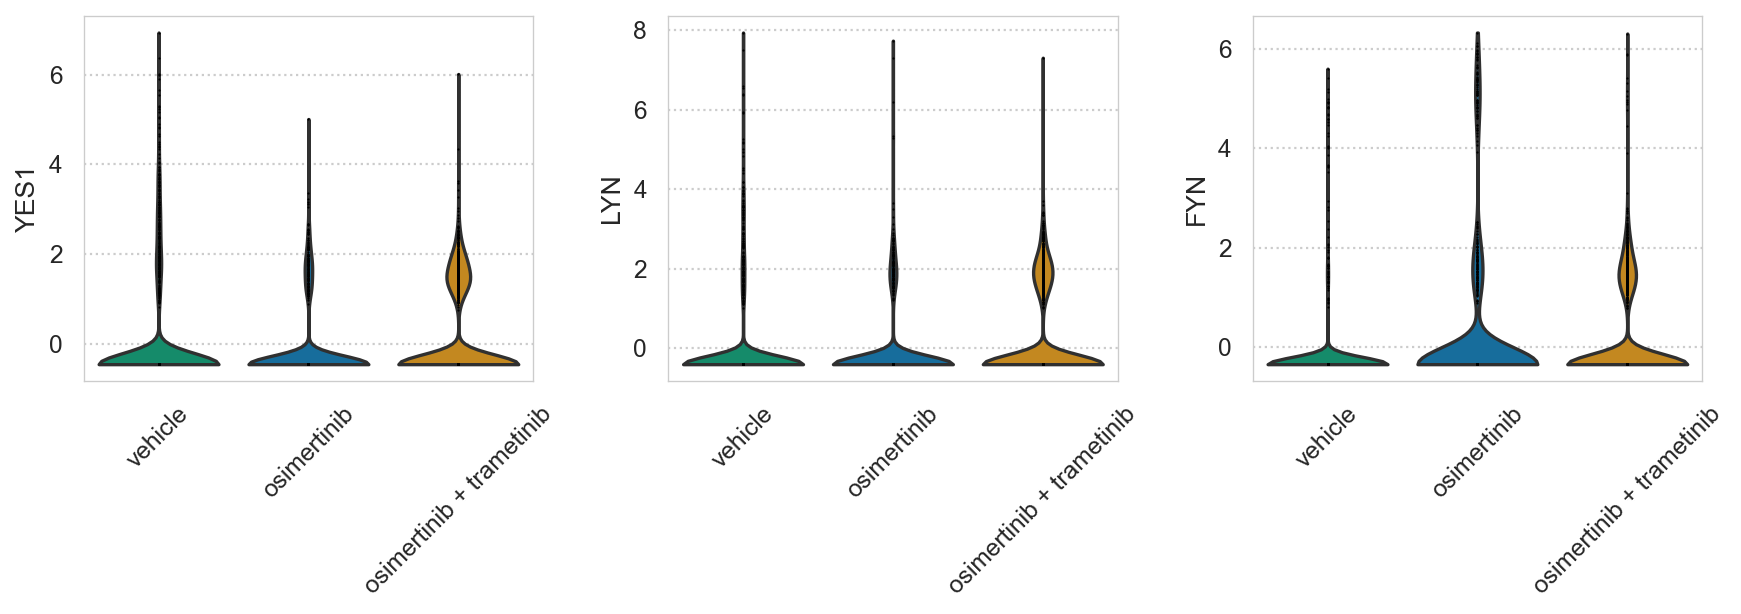

In [9]:
with plt.rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(vivo, keys=['YES1', "LYN", "FYN"], jitter=False, groupby='Treatment', rotation=45, order=["vehicle", "osimertinib", "osimertinib + trametinib"])

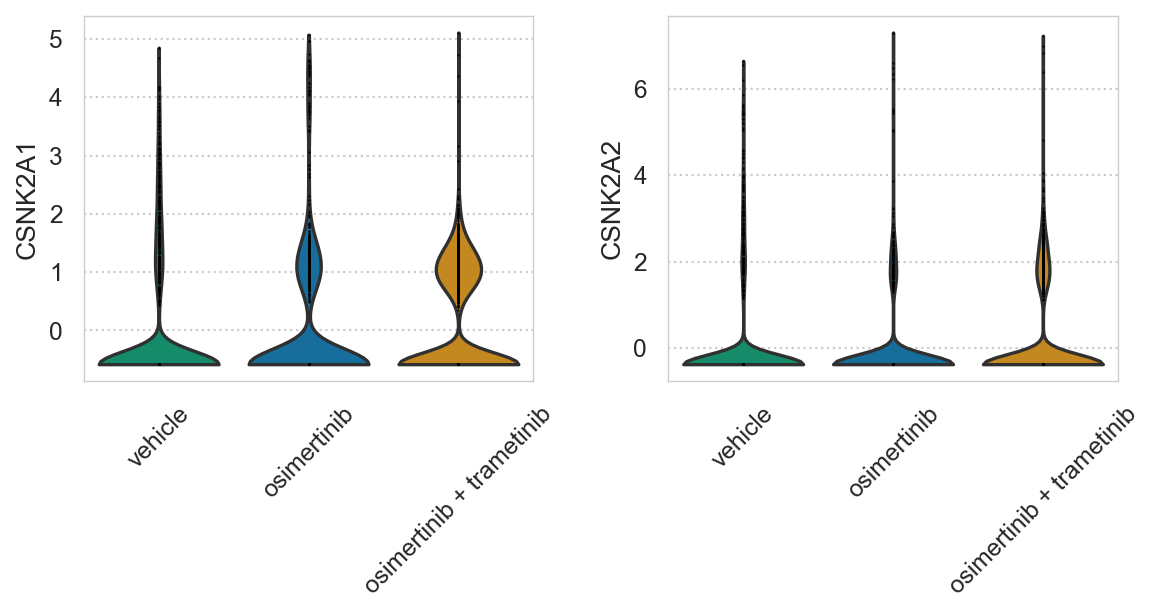

In [47]:
with plt.rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(vivo, keys=['CSNK2A1', "CSNK2A2"], jitter=False, groupby='Treatment', rotation=45, order=["vehicle", "osimertinib", "osimertinib + trametinib"])

/home/marcc/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


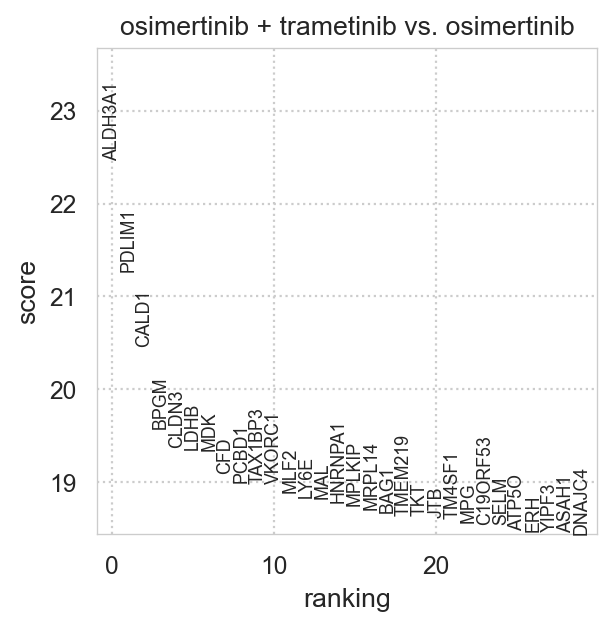

In [11]:
sc.tl.rank_genes_groups(vivo, 'Treatment', groups=["osimertinib + trametinib"], reference="osimertinib", method='wilcoxon', key_added ="wilcoxon")
sc.pl.rank_genes_groups(vivo, n_genes=30, sharey=False, key="wilcoxon")

/home/marcc/.local/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


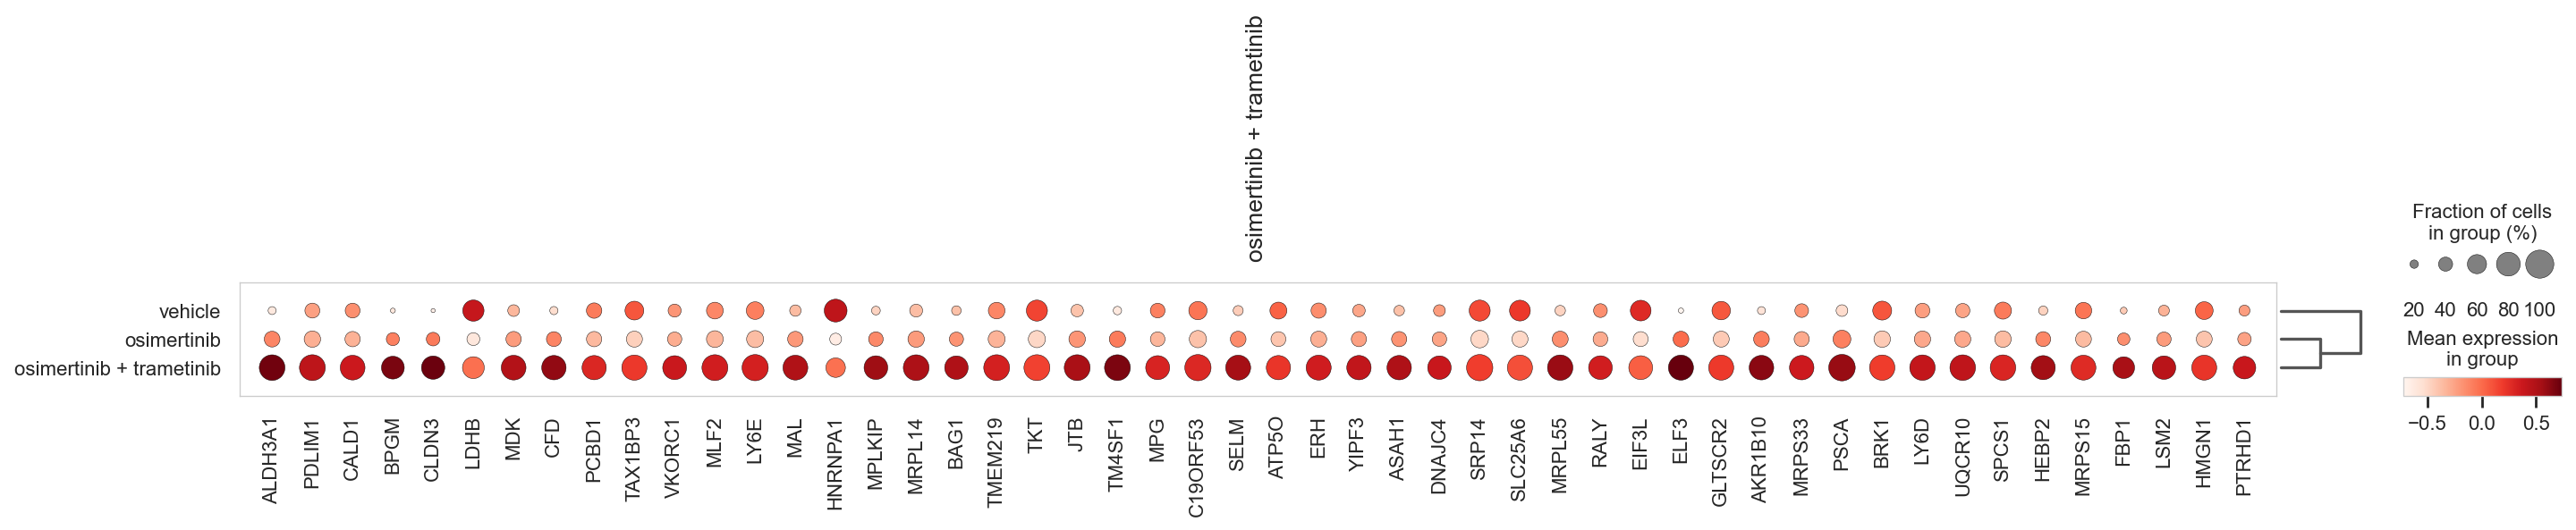

In [12]:
sc.pl.rank_genes_groups_dotplot(vivo, n_genes=50, key="wilcoxon", groupby="Treatment")

In [13]:
import gseapy as gp
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gp.get_library_name(organism='Human')
print(gene_set_names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and_Tissue_2021', 'Diabetes_Perturbations_GEO_2022', 'DisGeNET', 'Disease_Perturbations_from_GEO_down', 'Disease

In [14]:
#?gseapy.enrichr
glist = sc.get.rank_genes_groups_df(vivo, group="osimertinib + trametinib", 
                                    key='wilcoxon', log2fc_min=0.25, 
                                    pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
print(len(glist))

1046


In [125]:
sc.tl.rank_genes_groups(vivo, groupby="Treatment", use_raw=True)
dedf = sc.get.rank_genes_groups_df(vivo, group="osimertinib + trametinib")

/home/marcc/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marcc/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/marcc/.local/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


In [131]:
vivo.X

array([[-0.3095425 , -0.10785098, -0.7430768 , ..., -0.537197  ,
        -0.089735  , -0.11199981],
       [-0.3095425 , -0.10785098, -0.7430768 , ..., -0.537197  ,
        -0.089735  , -0.11199981],
       [ 5.37288   , -0.10785098, -0.7430768 , ..., -0.537197  ,
        -0.089735  , -0.11199981],
       ...,
       [-0.3095425 , -0.10785098,  0.6777783 , ...,  1.1542933 ,
        -0.089735  , -0.11199981],
       [-0.3095425 , -0.10785098, -0.7430768 , ..., -0.537197  ,
        -0.089735  , -0.11199981],
       [-0.3095425 , -0.10785098, -0.7430768 , ..., -0.537197  ,
        -0.089735  , -0.11199981]], dtype=float32)

In [127]:
dedf

,names,scores,logfoldchanges,pvals,pvals_adj
0,CLDN4,52.277977,NaN,0.0,0.0
1,ELF3,51.371021,NaN,0.0,0.0
2,ALDH3A1,49.690918,NaN,0.0,0.0
3,SOX4,48.999207,NaN,0.0,0.0
4,TM4SF1,47.361458,NaN,0.0,0.0
...,...,...,...,...,...
15775,RPL35,-40.770325,NaN,0.0,0.0
15776,RPS18,-41.134014,NaN,0.0,0.0
15777,RPL10,-41.357658,NaN,0.0,0.0
15778,RPL37,-41.531765,NaN,0.0,0.0


In [68]:
enr_res = gp.enrichr(gene_list=glist,
                     organism='Human',
                     gene_sets=['GO_Biological_Process_2021', "MSigDB_Hallmark_2020"],
                     cutoff = 0.5)

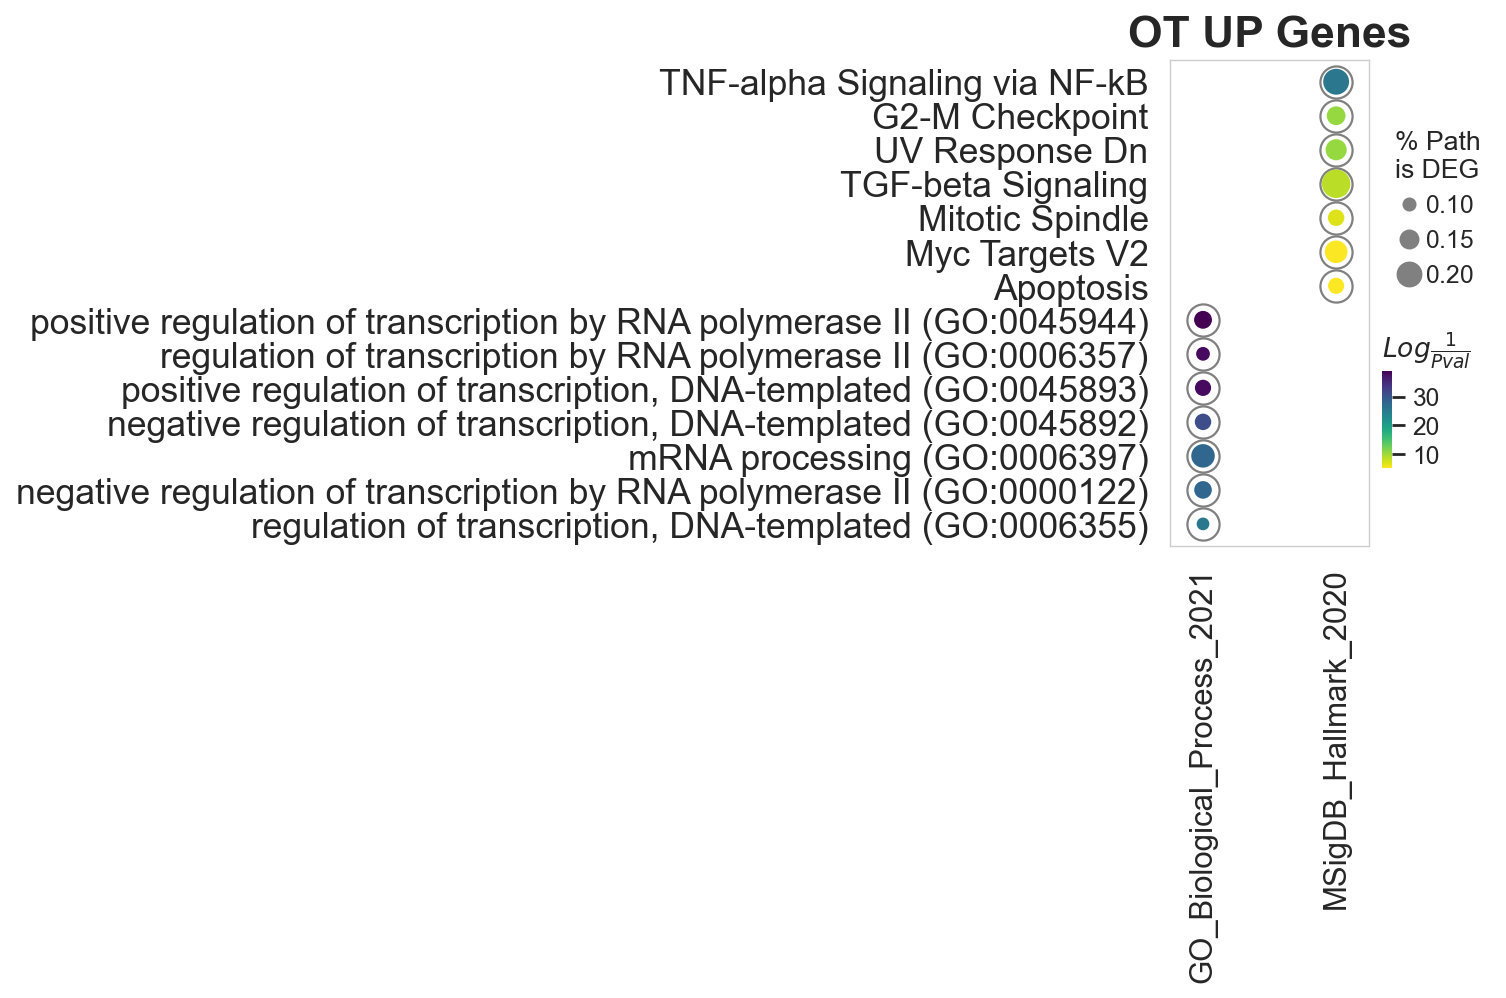

In [69]:
ax = gp.ringplot(enr_res.results, x='Gene_set', # set x, so you could do a multi-sample/dataset comparsion
              column="Adjusted P-value",
              size=20,
              top_term=7,
              figsize=(2,4),
              title = "OT UP Genes"
             )

In [35]:
gene_rank = sc.get.rank_genes_groups_df(vivo, group='osimertinib + trametinib', key='wilcoxon')[['names','logfoldchanges']]
gene_rank.sort_values(by=['logfoldchanges'], inplace=True, ascending=False)

In [36]:
# calculate_qc_metrics will calculate number of cells per gene
sc.pp.calculate_qc_metrics(vivo, percent_top=None, log1p=False, inplace=True)

# filter for genes expressed in at least 30 cells.
gene_rank = gene_rank[gene_rank['names'].isin(vivo.var_names[vivo.var.n_cells_by_counts>30])]

In [70]:
res = gp.prerank(rnk=gene_rank, gene_sets='Reactome_2022')

2022-10-05 16:58:36,638 Input gene rankings contains NA values(gene name and ranking value), drop them all!
